# <center>creado por Jorge Cardona</center>
# <center>jorgecardona@utp.edu.co</center>
# <center>Junio 9 de 2019</center>

# <p style="text-align: justify"> El área de conciliación ha decidido que se comience con el desarrollo del modelo analítico por sectores, comenzando con uno de los segmentos más críticos en el tema de morosidad, el segmento de pyme pequeña. El modelo de auto-cura posee una variable respuesta u objetivo, que se define como: * Toma el valor de 1 si la obligación es pagada en menos de 15 días (inclusive) sin realizarle gestiones o solamente gestiones de formato indirecto. * Toma el valor de 0 en cualquier otro caso.<p>

In [1]:
#libreria time para medir tiempos de ejecucion
import time 

# toma el tiempo antes de ejecutar todo el notebook
tiempo_inicial_ejecucion_notebook = time.time()

In [2]:
# configura el notebook para que las celdas tomen todo el ancho de la pantalla
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Fases del ciclo de vida del proceso de ciencia de datos
### El ciclo de vida de TDSP se compone de cinco fases principales que se ejecutan de forma iterativa. Estas fases incluyen:
* Conocimiento del negocio
* Adquisición y comprensión de los datos
* Modelado
* Implementación
* Aceptación del cliente

# 0. Informacion Importante 

In [3]:
#NULL -> Todavia no fue creado en una direccion Memoria, no existe. null se trata como 0 en operaciones aritméticas básicas.
#NaT means "Not A Time" -> No tiene Valor, Valor Faltante, si hay por lo menos un espacio en blanco ya no es NaT
#NaN means "Not A Number, Not A Value" -> No tiene Valor, Valor Faltante, si hay por lo menos un espacio en blanco ya no es NaN
#BLANK -> Existe en Memoria, pero No tiene un Valor Asignado, es considerado vacio : Empty.
#Zero "0" -> el valor inicial es cero
#libreria para tratamiento de datos desbalanceados
#pip install -U imbalanced-learn

# <center>1. CARGA DE LIBRERÍAS NECESARIAS</center>

In [4]:
# oculta los warnings del notebook
import warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings(action='once')

#importo numpy para hacer uso de sus operaciones con datos de tipo matriz
import numpy as np

# importo libreria para tratar los datos como tablas
import pandas as pd

# convierte cadena a diccionario
import ast
from collections import Counter

# libreria para datos al aleatorios
import random as rd

In [5]:
# importo bibliotecas para graficos
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import seaborn as sns
from pylab import rcParams

In [6]:
# importo librerias para preprocesamiento de datos
from sklearn import datasets, preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Importa la funcion que permite dividir el set de datos
from sklearn.model_selection import train_test_split

#Importo las metricas del modulo de scikit-learn para obtener los datos que me permiten medir el modelo
from sklearn import metrics

#Importo la libreria para hacer croos validation
from sklearn.model_selection import cross_val_score

#Importo los modelos de clasificacion
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

In [7]:
# instalar imbalanced-learn con permisos de administrador
# conda install -c conda-forge imbalanced-learn
# importo librerias para procesamiento de datos desbalanceados
from imblearn.over_sampling import ADASYN
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTENC

# <center>2. DECLARACIÓN DE VARIABLES Y CARGA DE DATASETS</center>

# Declaracion de nombres de datasets

In [8]:
# define el nivel de precision con que se muestran los datos en las columnas
#pd.set_option("display.precision", precision)

# archivo_base_entrenamiento = "Champions.xlsx"
archivo_base_entrenamiento = "Base_entrenamiento.csv"

# archivo que contiene la informacion con la cual se va a medir el modelo
archivo_base_aprobacion    = "Base_prueba.csv"

# Carga de datasets

In [9]:
# carga los datos de entrenamiento de un dataframe
df = pd.read_csv(archivo_base_entrenamiento)

#lista = ['dh_max_dia_otros_d', 'dh_max_dia_entradas', 'marca_info_cifin_decode', 'dh_max_dia_salidas', 'cpc_max_proc_deuda', 'dh_max_dia_pagos_d', 'pcons_tarjeta_de_credito', 'dia_pago', 'categoricasdos', 'cpc_avg_proc_deuda', 'pc_ind_ajustado', 'cluster_recod', 'anhomes_ciclo']

#df = df.drop(lista, axis=1)

# ordena las columnas del dataframe por orden alfabetico
df = df.reindex(sorted(df.columns), axis=1)

# carga los datos de validacion del modelo en un dataframe
df_validacion = pd.read_csv(archivo_base_aprobacion)
df_validacion = df_validacion.reindex(sorted(df.columns), axis=1)

# elimina los espacios en blanco de los nombres de las columnas, para evitar fallos posteriores, al utilizar lo
df = df.rename(columns=lambda x: x.strip())

In [10]:
df.shape

(20000, 124)

# Definicion de  y variable objetivo y declaracion de Variables Necesarias afectan el dataset y el analisis posterior, Carga de Informacion del dataset

In [11]:
# guarda una copia del dataset o conjunto de datos original
df_original = df.copy()

# obtiene el valor de las dimensiones del dataset cargado originalmente.
dimension_df_original = df_original.shape

# define del dataset cual es la columna que se quiere predecir
variable_a_predecir        = 'y_auto_cura'

# con este realizo el descarte de dimensiones que superen este valor
# este valor permite dividir el dataset original y crea 2 datasets entrenamiento y verificacion, para pruebas
limite_de_decision = 95

# valor que permite eliminar las columnas que sean mayor o igual al criterio de descarte porcentual
criterio_de_descarte = limite_de_decision

# define la cantidad de numeros decimales con que se mostraran los datos
precision = 3

# define el valor con el cual se van a trabajar los datos
# estas variables deben tener un valor de tipom porcentual entre 1 hasta 100
# define el tamano con que se va a dividir el dataset pata los clasificadores
tamano_conjunto_de_entrenamiento = 80

#define el numero maximo de validaciones cruzadas que se quieren realizar para cada modelo de clasificacion
cantidad_de_validaciones = 10

# son los clasificadores que se van a usar en el analisis

normales      = ['MLP','GB','NB','KNN','RF','DT','LR']
balanceadores = ['AD','ST','STE','RS','NM','LRP']

clasificadores = normales + balanceadores

# son los nombres de los valores que se esperan del clasificador
columnas_esperadas_del_clasificador = ['clasificador', 'area_bajo_la_curva', 'promedio_de_acierto_total','precision_no_paga', 'precision_si_paga','promedio_validacion_cruzada']

# bajo esta variable se va a realizar la eleccion del mejor clasificador
criterio_de_clasificador = 'promedio_de_acierto_total'

# <center>3. EXPRESIONES LAMBDA Y FUNCIONES</center>

# Expresiones Lambda

In [12]:
# expresion lambda que obtiene el listado de columnas que deben ser descartadas, bajo el criterio de repeticion de datos
# por ejemplo si se quiere eliminar las columnas donde un mismo dato cualquiera se repita o sea igual al 90% de las veces
# paso como primer parametro el dataframe y luegho el criterio de descarte porcentual asi por ejemplo: 
# columnas_a_eliminar_porcentage_descarte(nombres_columnas, criterio_de_descarte, df_original)
# usando List Comprehensions, se declara el valor a retornar, for, variable iteradora, in , criterio de iteracion, if , condicion que se cumple para retornar valor
# uso el criterio de que si el valor de mayor frecuencia dividido el total de datos de la muestra, supera el criterio_de_descarte, esa columna debe ser eliminada del dataset
columnas_a_eliminar_porcentage_descarte = lambda nombres_columnas, criterio_de_descarte, df_reducir : [nombres_columnas[i] for i in range(len(nombres_columnas)) if round(df_reducir[nombres_columnas[i]].value_counts().max() / df_reducir[nombres_columnas[i]].count(),precision) * 100 >= criterio_de_descarte]

# guarda los nombres de las columnas en que todos sus datos son iguales, usando el criterio en el cual si hay un solo dato de tipo unique, es que todos son el mismo dato, osea es un valor constante en toda la columna
columnas_a_eliminar_valores_iguales        = lambda nombres_columnas, df_reducir : [nombres_columnas[i] for i in range(len(nombres_columnas)) if (len(df_reducir[nombres_columnas[i]].unique()) == 1)]

# guarda los nombres de la columnas que tienen un desbalanceo de datos igual o superior al criterio de descarte, para eliminarlas del dataset
# uso el criterio de descarte en el cual si la cantidad de valores unicos son demasiados en la columna es igual o superior al criterio de descarte se elimina la columna
columnas_a_eliminar_por_desbalanceo_de_datos = lambda nombres_columnas, criterio_de_descarte, df_reducir : [nombres_columnas[i] for i in range(len(nombres_columnas)) if round(len(df_reducir[nombres_columnas[i]].unique()) / df_reducir[nombres_columnas[i]].count(),precision) * 100 >= criterio_de_descarte]

# definir cuales columnas son de tipo numerico y cuales columnas son string para definir columnas con variables categoricas
columnas_a_convertir_a_categoricas = lambda nombres_columnas, df_reducir : [nombres_columnas[i] for i in range(len(nombres_columnas)) if type(df_reducir[nombres_columnas[i]].sum()) == str ]

# Funciones

In [13]:
# elimina las filas que tengan en todas las columnas los valores que se quieran descartar
def filas_a_eliminar_valores_iguales_definidos (eliminar_valores, df_procesar):
    
    # recorre la lista de valores que se van a comparar para eliminar 
    for i in eliminar_valores: 
        
        # compara si en toda la fila existe el valor, de ser asi elimina la fila 
        df_procesar = df_procesar[(df_procesar.T != i).any()]
    
    # retorna el dataframe reducido
    return df_procesar 

In [14]:
# permite convertir las columnas tipo string en columnas categoricas
def convertir_columna_a_tipo_categorica(modificar_columnas, df_procesar):

    # recorre la lista de entrada
    for col in modificar_columnas:
        
        # convierte las columnas leidas en typo categoricas
        # cat.codes asigna los valores numericos para cada categoria
        df_procesar[col] = df_procesar[col].astype('category').cat.codes
    
    # retorna el dataset con las variables categoricas
    return df_procesar

In [15]:
# completa los valores que no estan en las filas con la media de la columna
def completar_datos_faltantes_del_dataset (df_procesar):
    
    # recorre el dataframe
    for col in nombres_columnas:
        
        # verifica si la columna es de tipo str, si es asi es categorica, por lo tanto se usa la moda
        if (type(df_procesar[col].sum()) == str):   
            # inserta los valores de la media donde estan los valores NaN o NaT
            df_procesar[col] = df_procesar[col].fillna(round(df_procesar[col].mode(),precision))
        else:
            # inserta los valores de la media donde estan los valores NaN o NaT
            df_procesar[col] = df_procesar[col].fillna(round(df_procesar[col].mean(),precision))
            
    # retorna el dataframe procesado
    return df_procesar

In [16]:
# metodo que hace un pretratamiento de los datos del dataframe
# hace escalamiento de la imformacion dejandola mas viable para que sea usada por algoritmos de ML
def normalizar_datos(df_procesar, metodo_escalamiento, variable_a_predecir):
        
    # normalizamiento de datos
    from sklearn import preprocessing 

    # variable que va a guardar el dataframe ya normalizado 
    df_normalizado = ''
    valores_normalizacion = 0
    
    # Se elimina la variable a predecir del dataframe
    df_normalizar = df_procesar.drop(columns= variable_a_predecir ,axis=1)
    
    # obtengo los nombres de las columnas del dataframe que son las que voy a normalizar
    nombres_columnas_df_normalizar = list(df_normalizar.dtypes.index)
    
    # verifica si el metodo de normalizacion seleccionado es min_max_scaler
    if(metodo_escalamiento == 'min_max_scaler'):
        
        # utiliza el min_max_scaler para normalizar
        metodo_normalizacion = preprocessing.MinMaxScaler()        
        
        # Realizo la transformacion de cada dimension.
        valores_normalizacion = metodo_normalizacion.fit_transform(df_normalizar)
        
        # creo de nuevo el dataframe con los datos obtenidos del proceso de escalamiento
        df_normalizado = pd.DataFrame(valores_normalizacion, columns = nombres_columnas_df_normalizar)
        
        # adiciono la columna que habia eliminado
        df_normalizado[variable_a_predecir] = list(df_procesar[variable_a_predecir])
        
        # guarda el dataframe con todoslos datos normalizados y la columna de prediccion
        df_normalizado = df_normalizado
        
    # verifica si el metodo de normalizacion seleccionado es standard_scaler    
    elif(metodo_escalamiento == 'standard_scaler'):
        
        # utiliza el standard_scaler para normalizar
        metodo_normalizacion = preprocessing.StandardScaler()       
        
        # Realizo la transformacion de cada dimension.
        valores_normalizacion = metodo_normalizacion.fit(df_normalizar)
        valores_normalizacion = metodo_normalizacion.transform(df_normalizar)
        
        # creo de nuevo el dataframe con los datos obtenidos del proceso de escalamiento
        df_normalizado = pd.DataFrame(valores_normalizacion, columns = nombres_columnas_df_normalizar)
        
        # adiciono la columna que habia eliminado
        df_normalizado[variable_a_predecir] = list(df_procesar[variable_a_predecir])
        
        # guarda el dataframe con todoslos datos normalizados y la columna de prediccion
        df_normalizado = df_normalizado

    # verifica si el metodo de normalizacion seleccionado es normalizer_l1    
    elif(metodo_escalamiento == 'normalizer_l1'):
        
        # utiliza el normalizer_l1 para normalizar
        normalizer_l1 = preprocessing.normalize(df_normalizar, norm= 'l1')  
        
        # obtengo los valores de normalizacion
        valores_normalizacion = normalizer_l1
        
        # creo de nuevo el dataframe con los datos obtenidos del proceso de escalamiento
        df_normalizado = pd.DataFrame(normalizer_l1, columns = nombres_columnas_df_normalizar)
        
        
        # adiciono la columna que habia eliminado
        df_normalizado[variable_a_predecir] = list(df_procesar[variable_a_predecir])
        
        # guarda el dataframe con todoslos datos normalizados y la columna de prediccion
        df_normalizado = df_normalizado        
        
    # verifica si el metodo de normalizacion seleccionado es normalizer_l2    
    elif(metodo_escalamiento == 'normalizer_l2'):
        
        # utiliza el normalizer_l1 para normalizar
        normalizer_l2 = preprocessing.normalize(df_normalizar, norm= 'l2') 
        
        # obtengo los valores de normalizacion
        valores_normalizacion = normalizer_l2
        
        # creo de nuevo el dataframe con los datos obtenidos del proceso de escalamiento
        df_normalizado = pd.DataFrame(normalizer_l2, columns = nombres_columnas_df_normalizar)
        
        # adiciono la columna que habia eliminado
        df_normalizado[variable_a_predecir] = list(df_procesar[variable_a_predecir])
        
        # guarda el dataframe con todoslos datos normalizados y la columna de prediccion
        df_normalizado = df_normalizado
        
    # retorna el dataset ya normalizado con el emetodo que se eligio
    return df_normalizado, valores_normalizacion

In [17]:
# permite disminuir el numero de dimensiones del dataset
def reducir_dimensiones (valores_normalizados, limite_de_decision):
       
    #Instanciamos objeto PCA y aplicamos
    componentes_reducidos=PCA(limite_de_decision / 100) # Otra opción es instanciar pca sólo con dimensiones nuevas hasta obtener un mínimo "explicado" ej.: pca=PCA(.85)
    componentes_reducidos.fit(valores_min_max_scaler) # obtener los componentes principales
    valores_componentes_reducidos=componentes_reducidos.transform(valores_normalizados) # convertimos nuestros datos con las nuevas dimensiones de PCA
    
    # muestra los porcentages de aporte de cada componente recomendado del dataset
    aporte_por_componente = componentes_reducidos.explained_variance_ratio_
    
    # suman los aportes de las variables sugeridas por la tecnica de reduccion de componentes
    total_aportado_por_los_componentes = sum(aporte_por_componente[0:valores_componentes_reducidos.shape[1]])
    
    #print("El total de dimensiones sugeridas para la confianza deseada en el modelo es :", valores_componentes_reducidos.shape[1])
    #print('La confianza calculada  del modelo con las dimensiones elegidas es :', round(total_aportado_por_los_componentes,precision) * 100)
    #print('el aporte individual de cada dimension es :')
    #print(aporte_por_componente)
    
    return componentes_reducidos, valores_componentes_reducidos 

In [18]:
# muestra la grafica con la tendencia de crecimiento de la confianza a base de los componentes proncipales hallados
def graficar_dimensiones_principales(componentes_reducidos, valores_componentes_reducidos, df_redimensionado, variable_a_predecir):
       
    # define las dimensiones con que se van a realizar los graficos
    altura_grafica = 9
    largo_grafica  = 32
    
    # define el tamaño de la grafica 
    plt.rcParams['figure.figsize'] = (largo_grafica, altura_grafica)
    
    # ubica la legenda que los marcadores en la posicion (0,0) del plano
    plt.rcParams["legend.handlelength"] = 0

    plt.style.use('ggplot')
    
    #graficamos el acumulado de varianza explicada en las nuevas dimensiones
    plt.plot(np.cumsum(componentes_reducidos.explained_variance_ratio_))
    plt.title('Se recomienda usar ' + str(valores_componentes_reducidos.shape[1]) + " componentes, Para obtener la confiabilidad parametrizada del limite_de_decision de " + str(limite_de_decision) + "%")
    plt.xlabel('cantidad de Componentes', fontsize=30)
    plt.ylabel('% Explicacion del modelo', fontsize=30)
    plt.show()
    
    #graficamos en 2 Dimensiones, tomando los 2 primeros componentes principales
    primer_componente = valores_componentes_reducidos[:,0]
    segundo_componente = valores_componentes_reducidos[:,1]
    
    etiquetas_da_la_columna_a_predecir =df_redimensionado[variable_a_predecir].values
    color_marcador={0:'green',1:'yellow'}
    explicacion_etiqueta={0:'no paga',1:'paga'}
    
    # los simbolos que se muestran en la grafica
    tipo_marcador={0:"^",1:"X"}
    
    alpha={0:.3, 1:.5}
    fig,eje=plt.subplots(figsize=(largo_grafica, altura_grafica))
    fig.patch.set_facecolor('white')

    # recorre los valores
    for opcion_pago in np.unique(etiquetas_da_la_columna_a_predecir):
        elemento=np.where(etiquetas_da_la_columna_a_predecir==opcion_pago)
        
        # ubica los valores en al grafica
        eje.scatter(primer_componente[elemento],segundo_componente[elemento],c=color_marcador[opcion_pago],label=explicacion_etiqueta[opcion_pago],s=40,marker=tipo_marcador[opcion_pago],alpha=alpha[opcion_pago])

    plt.title('variacion de pago en componentes principales')
    plt.xlabel("Primer Componente Principal",fontsize=30)
    plt.ylabel("Segundo Componente Principal",fontsize=30)
    plt.legend()
    plt.show()

In [19]:
# permite extraer directamente los componentes principales del dataset y generar el nuevo dataset para procesamiento de datos
def obtener_componentes_principales(df_procesar, variable_a_predecir, dimensiones_recomendadas, tipo_orden):
    
    df_base = df_procesar
    # eilimina ka variable objetivo para no afectar el dataset
    df_componentes = df_procesar.drop(columns= variable_a_predecir ,axis=1)
    
    # realiza escalamiento de los datos
    scale_data = preprocessing.scale(df_componentes)

    # utilizo el PCA para reducir dimensiones
    pca = PCA()
    pca.fit(scale_data)
    pca_data = pca.transform(scale_data)
    
    componentes_pca = 0
    
    # decido que ordene de menor a mayor
    if (tipo_orden == 'ascendente'):        
        tipo_orden = True
        
    # decido que ordene de mayor a menor    
    elif (tipo_orden == 'descendente'):
        tipo_orden = False
        
    # decido que ordene de mayor a menor
    else:
        tipo_orden = False

    # extraigo las dimensiones mas relevantes 
    for i in range (dimensiones_recomendadas):
        # adiciona la cantidad de dimensiones que se necesitan en el modelo para cumplir el criterio del limite_de_decision
        componentes_pca += pca.components_[i]
    
    # contiene el dataset procesado en eigen valores
    aportes_componentes = pd.Series(componentes_pca, index = df_componentes.columns)

    # ordena los componenetes de mayor a menor aporte porcentual en la muestra
    ordenar_aportes_componentes = aportes_componentes.abs().sort_values(ascending = True)

    #guarda el listado de las dimensiones a tener en cuenta para el nuevo dataset
    top_componentes = list(ordenar_aportes_componentes[0:dimensiones_recomendadas].index.values)
    top_componentes.append(variable_a_predecir)
    
    # tiene el nombre de todas las columnas del dataframe de entrada
    columnas_descartables = list(df_base.columns)
    
    # recorre los valores del top components y los elimina
    for i in top_componentes:
        
        # guarda el nombre de las dimensiones que no van a estar en el nuevo dataframe
        columnas_descartables.remove(i)

    # retorna el nuevo dataframe, con las columnas recomendadas por el algoritmo
    return df_procesar.drop(columns= columnas_descartables ,axis=1)

In [20]:
# divide el dataset en 2 fraciones una de 80% y otra de 20%
# el numero que fue asignado al random state, hace que siempre se genere la misma secuencia 
# si se cambia el valor del random state, tambien se cambia la secuencia generada
# si se quita el parametro random_state, sera generada una secuencia distinta cda vez que se ejecute
def generar_datasets_entrenamiento_validacion(df_procesar, limite_de_decision):
    
    # genera los datasets de entrenamiento y validacion
    dataset_entrenamiento = df_procesar.sample(frac=limite_de_decision / 100,random_state=200)
    dataset_validacion    = df_procesar.drop(dataset_entrenamiento.index)
    
    # reinicio los indices de cada dataset, para que tengan los indices sucesivos
    dataset_entrenamiento.reset_index(inplace=True, drop=True)
    dataset_validacion.reset_index(inplace=True, drop=True)
    
    # retorna los datasets de entrenamiento y validacion
    return dataset_entrenamiento, dataset_validacion

In [21]:
# crea los conjuntos de datos para que se usen en los clasificadores
def crear_conjunto_de_datos_para_clasificador (dataset_redimensionar, variable_a_predecir, tamano_conjunto_de_entrenamiento):

    X = dataset_redimensionar.drop(columns = variable_a_predecir ,axis=1)  # Features
    y = dataset_redimensionar[variable_a_predecir]  # Labels

    # Divide el dataset en 2 conjuntos de datos, uno de entrenamiento y otro de prueba, divide que el 70% sea para entreanmeinto y 30% para validacion 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = (100 - tamano_conjunto_de_entrenamiento) / 100, random_state=1, stratify=y)
    
    # retorna los conjuntos e datos para usar en el clasificador
    return X_train, X_test, y_train, y_test 

In [22]:
# permite evaluar los modelos de clasificacion utilizados con el dataset
def entrenar_evaluar_y_predecir_usando_el_modelo_de_clasificacion (clasificador, conjunto_de_datos_para_clasificador, precision, cantidad_de_validaciones, tipo_de_servicio):    
          
    #define como interpretar los datos del dataset
    LABELS = ['NO PAGA','PAGA']
        
    #guarda los datos del clasificador
    prediccion_obtenida = ''
    
    # muestra la informacion del comportamiento del modelo con cross validation
    valores_cross_validation = ''
    

    ######################################################################################################################################################################################
    ######################################################################################################################################################################################
    ########################################### CLASIFICADORES DE MACHINE LEARNING ESPECIALES PARA DATA DESBALANCEADA ####################################################################
    ######################################################################################################################################################################################
    ######################################################################################################################################################################################
    
    # LogisticRegression    
    if(clasificador == 'LRP'):

        #genera un clasificador
        modelo_de_clasificacion = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg",class_weight="balanced")

        #Entrena el modelo usando los sets de entrenamiento y dimensiones_de_analisis_test 
        modelo_de_clasificacion.fit(conjunto_de_datos_para_clasificador[0],conjunto_de_datos_para_clasificador[2])

        # guarada los datos de la prediccion
        prediccion_obtenida = modelo_de_clasificacion.predict(conjunto_de_datos_para_clasificador[1])   
        
        #obtiene los resultados de la validacion cruzada para ver el comportamiento 
        valores_cross_validation = cross_val_score(modelo_de_clasificacion, conjunto_de_datos_para_clasificador[0],conjunto_de_datos_para_clasificador[2], cv=cantidad_de_validaciones)
       
    # ADASYN    
    elif(clasificador == 'AD'):

        #genera un clasificador
        modelo_de_clasificacion = ADASYN(random_state=42)

        #Entrena el modelo usando los sets de entrenamiento y dimensiones_de_analisis_test 
        X_train_res , Y_train_res = modelo_de_clasificacion.fit_sample(conjunto_de_datos_para_clasificador[0],conjunto_de_datos_para_clasificador[2])
        
        # calcula el modelo con los datos de entreaanmiento y prediccion anteriores basado en regersion logistica        
        modelo_de_clasificacion = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg").fit(X_train_res, Y_train_res)

        # guarada los datos de la prediccion
        prediccion_obtenida = modelo_de_clasificacion.predict(conjunto_de_datos_para_clasificador[1])
        
        #obtiene los resultados de la validacion cruzada para ver el comportamiento 
        valores_cross_validation = cross_val_score(modelo_de_clasificacion, conjunto_de_datos_para_clasificador[0],conjunto_de_datos_para_clasificador[2], cv=cantidad_de_validaciones)        
        
    # NearMiss    
    elif(clasificador == 'NM'):

        #genera un clasificador
        modelo_de_clasificacion = NearMiss(ratio=0.5, n_neighbors=3, version=2, random_state=1)

        #Entrena el modelo usando los sets de entrenamiento y dimensiones_de_analisis_test 
        X_train_res , Y_train_res = modelo_de_clasificacion.fit_sample(conjunto_de_datos_para_clasificador[0],conjunto_de_datos_para_clasificador[2])
        
        # calcula el modelo con los datos de entreaanmiento y prediccion anteriores basado en regersion logistica        
        modelo_de_clasificacion = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg").fit(X_train_res, Y_train_res)

        # guarada los datos de la prediccion
        prediccion_obtenida = modelo_de_clasificacion.predict(conjunto_de_datos_para_clasificador[1])
        
        #obtiene los resultados de la validacion cruzada para ver el comportamiento 
        valores_cross_validation = cross_val_score(modelo_de_clasificacion, conjunto_de_datos_para_clasificador[0],conjunto_de_datos_para_clasificador[2], cv=cantidad_de_validaciones)

    # RandomOverSampler    
    elif(clasificador == 'RS'):

        #genera un clasificador
        modelo_de_clasificacion = RandomOverSampler(ratio=0.5)

        #Entrena el modelo usando los sets de entrenamiento y dimensiones_de_analisis_test 
        X_train_res , Y_train_res = modelo_de_clasificacion.fit_sample(conjunto_de_datos_para_clasificador[0],conjunto_de_datos_para_clasificador[2])
        
        # calcula el modelo con los datos de entreaanmiento y prediccion anteriores basado en regersion logistica        
        modelo_de_clasificacion = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg").fit(X_train_res, Y_train_res)

        # guarada los datos de la prediccion
        prediccion_obtenida = modelo_de_clasificacion.predict(conjunto_de_datos_para_clasificador[1])
        
        #obtiene los resultados de la validacion cruzada para ver el comportamiento 
        valores_cross_validation = cross_val_score(modelo_de_clasificacion, conjunto_de_datos_para_clasificador[0],conjunto_de_datos_para_clasificador[2], cv=cantidad_de_validaciones)

    # SMOTETomek    
    elif(clasificador == 'ST'):

        #genera un clasificador
        modelo_de_clasificacion = SMOTETomek(ratio=0.5)

        #Entrena el modelo usando los sets de entrenamiento y dimensiones_de_analisis_test 
        X_train_res , Y_train_res = modelo_de_clasificacion.fit_sample(conjunto_de_datos_para_clasificador[0],conjunto_de_datos_para_clasificador[2])
        
        # calcula el modelo con los datos de entreaanmiento y prediccion anteriores basado en regersion logistica        
        modelo_de_clasificacion = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg").fit(X_train_res, Y_train_res)

        # guarada los datos de la prediccion
        prediccion_obtenida = modelo_de_clasificacion.predict(conjunto_de_datos_para_clasificador[1])
        
        #obtiene los resultados de la validacion cruzada para ver el comportamiento 
        valores_cross_validation = cross_val_score(modelo_de_clasificacion, conjunto_de_datos_para_clasificador[0],conjunto_de_datos_para_clasificador[2], cv=cantidad_de_validaciones)

    # SMOTENC    
    elif(clasificador == 'STE'):

        #genera un clasificador
        modelo_de_clasificacion = SMOTENC(random_state=42,categorical_features=[0,1])

        #Entrena el modelo usando los sets de entrenamiento y dimensiones_de_analisis_test 
        X_train_res , Y_train_res = modelo_de_clasificacion.fit_sample(conjunto_de_datos_para_clasificador[0],conjunto_de_datos_para_clasificador[2])
        
        # calcula el modelo con los datos de entreaanmiento y prediccion anteriores basado en regersion logistica        
        modelo_de_clasificacion = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg").fit(X_train_res, Y_train_res)

        # guarada los datos de la prediccion
        prediccion_obtenida = modelo_de_clasificacion.predict(conjunto_de_datos_para_clasificador[1])
        
        #obtiene los resultados de la validacion cruzada para ver el comportamiento 
        valores_cross_validation = cross_val_score(modelo_de_clasificacion, conjunto_de_datos_para_clasificador[0],conjunto_de_datos_para_clasificador[2], cv=cantidad_de_validaciones)
        
        
    ######################################################################################################################################################################################
    ######################################################################################################################################################################################
    ########################################### CLASIFICADORES DE MACHINE LEARNING ESPERANDO QUE LA DATA SEA BALANCEADA ##################################################################
    ######################################################################################################################################################################################
    ######################################################################################################################################################################################

    # MLPClassifier    
    elif(clasificador == 'MLP'):

        #genera un clasificador
        modelo_de_clasificacion =  MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)
        
        
        #Entrena el modelo usando los sets de entrenamiento y dimensiones_de_analisis_test 
        modelo_de_clasificacion.fit(conjunto_de_datos_para_clasificador[0],conjunto_de_datos_para_clasificador[2])

        # guarada los datos de la prediccion
        prediccion_obtenida = modelo_de_clasificacion.predict(conjunto_de_datos_para_clasificador[1])   
        
        #obtiene los resultados de la validacion cruzada para ver el comportamiento 
        valores_cross_validation = cross_val_score(modelo_de_clasificacion, conjunto_de_datos_para_clasificador[0],conjunto_de_datos_para_clasificador[2], cv=cantidad_de_validaciones)
 
    # GradientBoostingClassifier    
    elif(clasificador == 'GB'):

        #genera un clasificador
        modelo_de_clasificacion = GradientBoostingClassifier(n_estimators=1000, learning_rate = 1, max_features=2, max_depth = 10, random_state = 0)

        #Entrena el modelo usando los sets de entrenamiento y dimensiones_de_analisis_test 
        modelo_de_clasificacion.fit(conjunto_de_datos_para_clasificador[0],conjunto_de_datos_para_clasificador[2])

        # guarada los datos de la prediccion
        prediccion_obtenida = modelo_de_clasificacion.predict(conjunto_de_datos_para_clasificador[1])   
        
        #obtiene los resultados de la validacion cruzada para ver el comportamiento 
        valores_cross_validation = cross_val_score(modelo_de_clasificacion, conjunto_de_datos_para_clasificador[0],conjunto_de_datos_para_clasificador[2], cv=cantidad_de_validaciones)
 
    # GradientBoostingClassifier    
    elif(clasificador == 'NB'):

        #genera un clasificador
        modelo_de_clasificacion = GaussianNB(priors=None, var_smoothing=1e-09)

        #Entrena el modelo usando los sets de entrenamiento y dimensiones_de_analisis_test 
        modelo_de_clasificacion.fit(conjunto_de_datos_para_clasificador[0],conjunto_de_datos_para_clasificador[2])

        # guarada los datos de la prediccion
        prediccion_obtenida = modelo_de_clasificacion.predict(conjunto_de_datos_para_clasificador[1])   
        
        #obtiene los resultados de la validacion cruzada para ver el comportamiento 
        valores_cross_validation = cross_val_score(modelo_de_clasificacion, conjunto_de_datos_para_clasificador[0],conjunto_de_datos_para_clasificador[2], cv=cantidad_de_validaciones)
             
        
    # LogisticRegression    
    elif(clasificador == 'LR'):

        #genera un clasificador
        modelo_de_clasificacion = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial')

        #Entrena el modelo usando los sets de entrenamiento y dimensiones_de_analisis_test 
        modelo_de_clasificacion.fit(conjunto_de_datos_para_clasificador[0],conjunto_de_datos_para_clasificador[2])

        # guarada los datos de la prediccion
        prediccion_obtenida = modelo_de_clasificacion.predict(conjunto_de_datos_para_clasificador[1])   
        
        #obtiene los resultados de la validacion cruzada para ver el comportamiento 
        valores_cross_validation = cross_val_score(modelo_de_clasificacion, conjunto_de_datos_para_clasificador[0],conjunto_de_datos_para_clasificador[2], cv=cantidad_de_validaciones)
        
    # DecisionTreeClassifier    
    elif(clasificador == 'DT'):

        #genera un clasificador
        modelo_de_clasificacion = DecisionTreeClassifier(criterion="entropy", max_depth = 2)

        #Entrena el modelo usando los sets de entrenamiento y dimensiones_de_analisis_test 
        modelo_de_clasificacion.fit(conjunto_de_datos_para_clasificador[0],conjunto_de_datos_para_clasificador[2])

        # guarada los datos de la prediccion
        prediccion_obtenida = modelo_de_clasificacion.predict(conjunto_de_datos_para_clasificador[1])   
        
        #obtiene los resultados de la validacion cruzada para ver el comportamiento 
        valores_cross_validation = cross_val_score(modelo_de_clasificacion, conjunto_de_datos_para_clasificador[0],conjunto_de_datos_para_clasificador[2], cv=cantidad_de_validaciones)    
       
    # RandomForestClassifier
    elif(clasificador == 'RF'):        

        #genera un clasificador
        modelo_de_clasificacion = RandomForestClassifier(n_estimators=100)

        #Entrena el modelo usando los sets de entrenamiento y dimensiones_de_analisis_test 
        modelo_de_clasificacion.fit(conjunto_de_datos_para_clasificador[0],conjunto_de_datos_para_clasificador[2])

        prediccion_obtenida = modelo_de_clasificacion.predict(conjunto_de_datos_para_clasificador[1])
        
        #obtiene los resultados de la validacion cruzada para ver el comportamiento 
        valores_cross_validation = cross_val_score(modelo_de_clasificacion, conjunto_de_datos_para_clasificador[0],conjunto_de_datos_para_clasificador[2], cv=cantidad_de_validaciones)
        
    # KNeighborsClassifier
    elif(clasificador == 'KNN'):
        
        #genera un clasificador
        modelo_de_clasificacion = KNeighborsClassifier(n_neighbors=100)

        #Entrena el modelo usando los sets de entrenamiento y dimensiones_de_analisis_test 
        modelo_de_clasificacion.fit(conjunto_de_datos_para_clasificador[0],conjunto_de_datos_para_clasificador[2])

        # guarada los datos de la prediccion
        prediccion_obtenida = modelo_de_clasificacion.predict(conjunto_de_datos_para_clasificador[1])
        
        #obtiene los resultados de la validacion cruzada para ver el comportamiento 
        valores_cross_validation = cross_val_score(modelo_de_clasificacion, conjunto_de_datos_para_clasificador[0],conjunto_de_datos_para_clasificador[2], cv=cantidad_de_validaciones)
    
    # obtiene los valores de la validacion cruzada
    promedio_validacion_cruzada = round(np.mean(valores_cross_validation) * 100, precision)
    variacion_validacion_cruzada = round(np.std(valores_cross_validation) * 100, precision)    
    
    # verifica que sea para entrenamiento, dado que si es diferente de cero 0 se esta probando el modelo
    # si es cero es porque se busca encontrar el mejor clasificador
    if(tipo_de_servicio == 0) :       
        
        # calcula el area bajo la curva
        false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(conjunto_de_datos_para_clasificador[3], prediccion_obtenida)
        # obtengo los valores del area bajo la curva
        area_bajo_la_curva           = round(metrics.auc(false_positive_rate, true_positive_rate) * 100, precision)
        valor_roc_area_bajo_la_curva = round(metrics.roc_auc_score(conjunto_de_datos_para_clasificador[3], prediccion_obtenida) * 100, precision)

        ### genera la curva roc del modelo evaluadp con el clasificador actual
        lw = 2
        plt.figure(figsize=(8, 4))    
        plt.plot(false_positive_rate, true_positive_rate, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % area_bajo_la_curva)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Falsos Positivos Rate')
        plt.ylabel('Verdaderos Positivos Rate')
        plt.title('Comportamiento del clasificador ' + clasificador + ' bajo el criterio de la curva ROC')
        plt.legend(loc="lower right")
        plt.show()

        # genera la matriz de confusion y muestra un grafico de esta con el dataset evaluado    
        conf_matrix = metrics.confusion_matrix(conjunto_de_datos_para_clasificador[3], prediccion_obtenida)

        plt.figure(figsize=(8, 4))    
        sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
        plt.title("Matriz de Confusion para el clasificador " + clasificador)
        plt.ylabel('Clase Real')
        plt.xlabel('Clase Predecida')
        plt.show()
       
        # obtiene el porcentage de acierto de paga o no paga
        valores_no_paga, valores_paga = list(conf_matrix[0]), list(conf_matrix[1])
        precision_no_paga = round((valores_no_paga[0]) / (valores_no_paga[0] + valores_no_paga[1]) * 100, precision)
        precision_si_paga = round((valores_paga[1]) / (valores_paga[0] +  valores_paga[1]) * 100,precision)
        # verifica que tan bien clasifica

        #penalizo si el clasificador fallo mas en reconocer positivimante que en fallar
        # dandole prioridad a los que son mejores tanto para una clase como para la otra
        if (precision_no_paga >= 50 and precision_si_paga >= 50): 
            # calcula el promedio de acierto segun los parametros anteriores
            promedio_de_acierto_total = round((precision_no_paga + precision_si_paga) / 2, precision) 
        # ambos tienen promedio de aciertos por debajo de la media
        elif (precision_no_paga < 50 and precision_si_paga < 50): 
            # calcula el promedio de acierto segun los parametros anteriores, penalizo para que salga del promedio normal
            # le resto 50 para que quede mas abajo ya que ambos estan por debajo de la media
            promedio_de_acierto_total = abs(round((precision_no_paga + precision_si_paga) / 2, precision) - 50)          
            
        # garantiza que si uno de los 2 es esta por debajo de la media lo penaliza para que en el ordenamiento elija los positivos positivo.
        else: 
            # calcula el promedio de acierto segun los parametros anteriores, penalizo para que salga del promedio normal
            # resta 25 ya que con esto no debe superar el 49.9 
            promedio_de_acierto_total = abs(round((precision_no_paga + precision_si_paga) / 2, precision) - 25)
            
        # Verifica que tan bueno es el clasificador, con las veces que clasifico correctamente
        print("Accuracy: ", round(metrics.accuracy_score(conjunto_de_datos_para_clasificador[3], prediccion_obtenida) * 100 ,precision) ,"%")

        # Muestra Qué porcentaje de tuplas positivas se etiquetan como tales
        print("Precision: ", round(metrics.precision_score(conjunto_de_datos_para_clasificador[3], prediccion_obtenida) * 100 ,precision) ,"%")

        # Muestra Qué porcentaje de tuplas positivas se etiquetan como tales
        print("Recall: ", round(metrics.recall_score(conjunto_de_datos_para_clasificador[3], prediccion_obtenida) * 100 ,precision) ,"%")

        # Muestra Qué porcentaje de tuplas positivas se etiquetan como tales
        print("F1-Score: ", round(metrics.f1_score(conjunto_de_datos_para_clasificador[3], prediccion_obtenida) * 100 ,precision) ,"%")

        # Mestra el promedio de la validacion cruzada
        print("El promedio de Cross Validation para ", cantidad_de_validaciones, " validaciones es: ", promedio_validacion_cruzada, "% con una variabilidad de +/- ", variacion_validacion_cruzada ,"%") 

        # retorna los valores de medicion con su respectivo clasificador
        return clasificador, area_bajo_la_curva, promedio_de_acierto_total, precision_no_paga, precision_si_paga, promedio_validacion_cruzada , prediccion_obtenida
    
    # retorna solo la predicion, ya que sabe que es es conjunto de validacion de la informacion
    else:
        return list(prediccion_obtenida)

In [23]:
# evalua cada clasificador y retorna una dataframe ordenado de mayor a menor calidad
def evaluar_y_elegir_mejor_clasificador (clasificadores_a_evaluar, conjunto_de_datos_para_clasificador, precision, columnas_esperadas_del_clasificador, nombre_columna_decision_filtrado):
    
    # lista para guaradar los valores de los clasificadores
    rendimiento_clasificador = []
    
    #adiciona una columna mas, para poder traer el valor de prediccion del modelo
    columnas_esperadas_del_clasificador.append('prediccion clasificador')
    
    # recorre los clasificadores
    for clasificador_a_evaluar in clasificadores:
        rendimiento_clasificador.append(entrenar_evaluar_y_predecir_usando_el_modelo_de_clasificacion (clasificador_a_evaluar, conjunto_de_datos_para_clasificador, precision, cantidad_de_validaciones, 0))
        
    #Construye un dataframe con el nombre de columnas_esperadas_del_clasificador y los valores obtenidos de los clasificadores
    resultados_clasificadores = pd.DataFrame(list(rendimiento_clasificador),columns = columnas_esperadas_del_clasificador)
    
    # obtiene el indice donde esta el valor maximo de la columna
    x = int(resultados_clasificadores[resultados_clasificadores[nombre_columna_decision_filtrado] == resultados_clasificadores[nombre_columna_decision_filtrado].max()].index[0])
    
    #ordena de mayor a menor la columna del dataframe que se quiere basado en el criterio elegido por nombre_columna_decision_filtrado
    resultados_clasificadores = resultados_clasificadores.sort_values(by = nombre_columna_decision_filtrado, ascending = False)
    #crea una columna indice con valores ordenados segun el filtro anterior
    resultados_clasificadores = resultados_clasificadores.reset_index()
    # permite que indice de la columna inicie en el numero 1
    resultados_clasificadores.index += 1 
    resultados_clasificadores = resultados_clasificadores.drop(columns = 'index', axis=1)
    
    # elimina la ultima columna dle dataframe, por que no se va a mostrar la predicion en una sola fila
    resultados_clasificadores = resultados_clasificadores[resultados_clasificadores.columns[:-1]]

    
    #Construye un dataframe que guarda los resultados de prediccion del mejor clasificar identificado
    #resultados_prediccion_mejor_clasificador = pd.DataFrame(list(rendimiento_clasificador[x][6]), columns = 'Prediccion')
    
    # retorna los valores obtenidos de cada clasificador en un dataframe y retorna el nombre del clasificador mas viable
    return resultados_clasificadores, resultados_clasificadores[columnas_esperadas_del_clasificador[0]][1], list(rendimiento_clasificador[x][6])

In [24]:
# crea los conjuntos de datos para que se usen en los verificadores
def crear_conjunto_de_datos_para_prediccion (dataset_redimensionar, variable_a_predecir, df_predecir):
    
    X = dataset_redimensionar.drop(columns = variable_a_predecir ,axis=1)  # Features
    y = dataset_redimensionar[variable_a_predecir]  # Labels
    
    # es el conjunto de datos que se usa para el entrenamiento
    X_train = X
    # es la respuesta real del conjunto de datos de entrenamiento
    y_train = y
    #es el conjunto  de datos que se quiere predecir
    X_test  = df_predecir
    
    #no se va a usar porque se van a predecir datos qeu no se conocen
    y_test = ''

    # retorna los conjuntos e datos para usar en el clasificador
    return X_train, X_test, y_train, y_test

# <center>4. ANÁLISIS EXPLORATORIO Y PREPROCESAMIENTO DE LA INFORMACIÓN</center>

# Procesar datos vacios y Reemplazar por datos tipo NaN

In [25]:
# reemplaza el contenido de las celdas donde hay espacios en blanco por celda sin valor o vacio, con una sxpresion regular.
df = df.replace(r'^\s*$', "", regex=True)

# reemplaza los datos tipo vacion por datos tipo NaN
df = df.replace('', np.nan)

# Identificar Filas y Columnas duplicadas, para eliminarlas de los dataset

In [26]:
# elimina TODAS LAS COLUMNAS DUPLICADAS dejando solo una de ellas, donde todos los elementos de cada columna son iguales.
df = df.T.drop_duplicates().T

# elimina TODAS LAS FILAS DUPLICADAS dejando solo una de ellas, donde todos los elementos de cada fila son iguales.
df = df.drop_duplicates()

In [27]:
df.shape

(20000, 109)

# Identificar Filas y Columnas que solo tengan valores NaN o NaT, para eliminarlas de los dataset

In [28]:
# elimina TODAS LAS COLUMNAS donde las celdas TENGAN UN MISMO VALOR NaN o NaT.
df = df.T.dropna(how='all').T

# elimina TODAS LAS FILAS donde las celdas TENGAN UN MISMO VALOR NaN o NaT.
df = df.dropna(how='all')

In [29]:
df.shape

(20000, 109)

# Obtener Variables Categoricas y  Convertir Variables Categoricas a Numericas

In [30]:
# guarda el nombre de las columnas del dataset en esta variable
nombres_columnas = list(df)

# convierte las columnas de texto en tipo categoricas
modificar_columnas = columnas_a_convertir_a_categoricas(nombres_columnas, df)

# convierte las variables categoricas en numericas
# obtiene el dataframe con las columnas en formato numerico
df = convertir_columna_a_tipo_categorica(modificar_columnas, df) 

# Completar Datos Faltantes, usando el criterio de la media y la moda

In [31]:
# balancea los datos faltantes de cada fila y columna con la media de cada columna
df = completar_datos_faltantes_del_dataset(df)

# Identifica y elimina TODAS LAS COLUMNAS donde las celdas TENGAN UN MISMO VALOR.

In [32]:
# usa la expresion lambda para obtener la lista de las columnas a descartar
columnas_a_eliminar   = columnas_a_eliminar_porcentage_descarte(nombres_columnas, criterio_de_descarte, df) 
columnas_a_eliminar  += columnas_a_eliminar_valores_iguales(nombres_columnas, df)
columnas_a_eliminar  += columnas_a_eliminar_por_desbalanceo_de_datos(nombres_columnas, criterio_de_descarte, df)

# elimina los elementos repetidos en la lista para evitar que falle al intentar borra una columna que ya no existe
columnas_a_eliminar  = set(columnas_a_eliminar)

# elimina las columnas obtenidas por columnas_a_eliminar
df = df.drop(columnas_a_eliminar , axis=1)

# otra manera de eliminar columnas donde todos los campos de la columna tengan un valor especifico
# elimina TODAS LAS COLUMNAS donde las celdas TENGAN UN MISMO VALOR, en este caso que sean vacio o que no tengan valores.
#df = df.loc[:, (df != 0).any(axis = 0)]

In [33]:
df.shape

(20000, 73)

# Identifica y  elimina las filas que tengan un valor especifico 

In [34]:
# se guardan los valores con que, las filas van a ser eliminaadas, si todas sus celdas contienen el mismo valor
eliminar_valores = [0, np.nan]

# elimina las filas en donde toda la fila tenga el mismo valor definidos en la lista eliminar_valores
df = filas_a_eliminar_valores_iguales_definidos(eliminar_valores,df)

# obtiene el total de columnas del dataset
total_columnas_dataset_depurado = len(df.columns)

# establece la cantidad de columnas del dataset que se puede ver en la casilla del notebook
pd.set_option('display.max_columns', total_columnas_dataset_depurado)

In [35]:
df.shape

(20000, 73)

# Observamos los datos del dataset  y verificamos si se puede usar algun criterio para eliminar mas dimensiones

In [36]:
# tengo el dataframe con las estadisticas que pueden mostrar otra dimension que pueda ser eliminada del dataset
df

,anhomes_ciclo,cluster_recod,cpc_avg_nro_cuota,cpc_avg_proc_deuda,cpc_avg_saldo,cpc_max_nro_cuota,cpc_max_proc_deuda,cpc_nro_cuota_tdc,cpc_saldo_sobre_ing,cpc_saldo_tdc,cpc_sum_nro_cuota,cpc_sum_proc_deuda,cpc_sum_saldo,desv_bim,desv_sem,desv_trim,dh_avg_dia_entradas,dh_avg_dia_pagos_d,dh_avg_dia_retiros_d,dh_avg_dia_salidas,dh_cant_entradas,dh_cant_otros_d,dh_cant_pago_tarj_d,dh_cant_pagos_d,dh_cant_salidas,dh_cant_tras_d,dh_max_dia_comisio_d,dh_max_dia_entradas,dh_max_dia_otros_d,dh_max_dia_pago_tarj_d,dh_max_dia_pagos_d,dh_max_dia_retiros_d,dh_max_dia_salidas,dh_min_dia_entradas,dh_min_dia_otros_d,dh_min_dia_pago_cred_d,dh_min_dia_pago_tarj_d,dh_min_dia_pagos_d,dh_min_dia_tras_d,dh_val_entradas,dh_val_otros_d,dh_val_pago_tarj_d,dh_val_pagos_d,dh_val_retiros_d,dh_val_salidas,dia_pago,dmi_egreso_total_mes,dmi_max_egreso_diario,dmi_max_ingreso_diario,marca_info_cifin_decode,max_bim,max_mes_anterior,max_sem,max_trim,pc_cant_mora90_ult_12m_total,pc_cant_moras_30_ult_12_meses,pc_cant_moras_30_ult_3_meses,pc_cant_moras_60_ult_12_meses,pc_cant_moras_60_ult_3_meses,pc_cant_moras_90_ult_12_meses,pc_cuotas_pagadas,pc_gasto_familiar,pc_ind_ajustado,pc_ingreso_final,pc_ingreso_por_rutina,pc_ingreso_rutina_con_techo,pc_transaccional,pcons_tarjeta_de_credito,pcons_vehiculos_sufi,prom_bim,prom_sem,prom_trim,y_auto_cura
0,201608,13,0.00,0.000000,0.000000e+00,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000e+00,4.949747,2.857738,4.041452,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2,7,7,7,7,0.0,1.0,1.0,0.0,0.0,0.0,0.000000e+00,7.650000e+05,1.606500e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,0,0,3.5,1.166667,2.333333,0
1,201611,13,0.00,0.000000,0.000000e+00,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000e+00,7.071068,7.641989,5.773503,6.046296,3.428571,16.600000,8.810053,14,2,0,8,28,0,20,30,20,0,27,31,31,2,13,13,0,13,0,4452485,22651,0,3085738,1797602,4921015,1,4921015,2061032,2210300,0,17,17,17,17,0.0,1.0,0.0,0.0,0.0,0.0,0.000000e+00,2.313090e+06,2.931842e+06,6.553755e+06,7.710300e+06,7.710300e+06,7.710300e+06,0,0,12.0,8.000000,13.666667,0
2,201705,13,0.00,0.000000,0.000000e+00,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000e+00,19.091883,12.868566,13.527749,8.291667,1.166667,22.000000,10.500000,5,2,0,1,11,0,27,30,27,0,7,27,27,7,7,7,0,7,0,3187600,20200,0,1,3031542,3055581,1,3055581,2131531,1858600,0,27,27,36,27,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,1.701088e+06,3.572286e+06,6.670935e+06,6.670935e+06,6.670935e+06,6.670935e+06,0,0,13.5,21.000000,14.000000,0
3,201609,13,0.00,0.000000,0.000000e+00,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000e+00,19.091883,10.888832,15.588457,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,27,0,0,0,2,27,27,27,27,0.0,1.0,1.0,0.0,0.0,0.0,0.000000e+00,7.650000e+05,1.606500e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,0,0,13.5,4.833333,9.000000,0
4,201702,13,0.00,0.000000,0.000000e+00,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000e+00,14.142136,11.651895,16.165808,10.000000,3.350000,16.200000,9.190000,2,0,0,4,10,0,13,31,0,0,27,27,27,19,0,2,0,2,0,1000000,0,0,1978774,7962,1998986,27,1998986,1002318,1000000,0,20,20,32,32,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,9.450000e+05,1.197788e+06,2.677500e+06,3.150000e+06,3.150000e+06,3.150000e+06,0,0,10.0,20.833333,17.333333,0
5,201705,13,0.00,0.000000,0.000000e+00,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000e+00,2.121320,11.906581,1.527525,8.291667,1.166667,22.000000,10.500000,5,2,0,1,11,0,27,30,27,0,7,27,27,7,7,7,0,7,0,3187600,20200,0,1,3031542,3055581,27,3055581,2131531,1858600,0,30,27,32,30,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,1.701088e+06,3.572286e+06,6.670935e+06,6.670935e+06,6.670935e+06,6.670935e+06,0,0,28.5,22.833333,28.333333,0
6,201607,6,0.00,0.000000,0.000000e+00,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,

In [37]:
# lista de columnas que considero podria eliminar dado que son calculadas de otras columnas
dimensiones_suprimibles = ['desv_bim','desv_trim','desv_sem','prom_bim','prom_trim','prom_sem']

# no elimino ninguna dimension, lo dejo a cargo del algoritmo de reduccion de dimensiones
dimensiones_suprimibles = []

# elimina las columnas del dataframe
# creo un nuevo dataframe con las dimensiones que se eliminaron
# con este dataframe se hara el proceso de normalizacion
df_redimensionado = df.drop(columns=dimensiones_suprimibles, axis=1).copy()

# obtiene el valor de las dimensiones del dataset depurado.
dimension_df_redimensionado = df_redimensionado.shape

In [38]:
print("la dimension original de dataset es :" , dimension_df_original)
print("la dimension actual de dataset con eliminacion manual es :" , dimension_df_redimensionado)

la dimension original de dataset es : (20000, 124)
la dimension actual de dataset con eliminacion manual es : (20000, 73)


In [39]:
# como no se hizo reduccion de dimensiones uso el algoritmo de la importancia de dimensiones, para ver como se comporta el dataset
#importancia_de_dimensiones = pd.Series(clf.feature_importances_,index = df_redimensionado.drop(columns= variable_a_predecir ,axis=1).columns).sort_values(ascending=False)
#importancia_de_dimensiones

# <center>5. NORMALIZACIÓN DE LA INFORMACIÓN</center>

# Normalizacion de los datos del dataset

In [40]:
# obtengo los dataframe normalizados con los metodos definidos al dataset redimensionado
dataset_normalizado_min_max_scaler, valores_min_max_scaler   = normalizar_datos(df_redimensionado, 'min_max_scaler' ,variable_a_predecir)
dataset_normalizado_standard_scaler, valores_standard_scaler = normalizar_datos(df_redimensionado, 'standard_scaler' ,variable_a_predecir)
dataset_normalizado_normalizer_l1, valores_normalizer_l1     = normalizar_datos(df_redimensionado, 'normalizer_l1' ,variable_a_predecir)
dataset_normalizado_normalizer_l2, valores_normalizer_l2     = normalizar_datos(df_redimensionado, 'normalizer_l2' ,variable_a_predecir)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


# <center>6. REDUCCIÓN DE DIMENSIONES</center>

# Reduccion de las dimensiones del dataset

In [41]:
# obtiene los dataset redimensionados con dataset reducido
#componentes_reducidos_min_max_scaler, valores_componentes_reducidos_min_max_scaler, listado_componentes_principales  = reducir_dimensiones2 (valores_min_max_scaler, limite_de_decision , dataset_normalizado_min_max_scaler)
componentes_reducidos_min_max_scaler, valores_componentes_reducidos_min_max_scaler  = reducir_dimensiones (valores_min_max_scaler, limite_de_decision)
componentes_reducidos_standard_scaler, valores_componentes_reducidos_standard_scaler  = reducir_dimensiones (valores_standard_scaler, limite_de_decision)
componentes_reducidos_normalizer_l1, valores_componentes_reducidos_normalizer_l1  = reducir_dimensiones (valores_normalizer_l1, limite_de_decision)
componentes_reducidos_normalizer_l2, valores_componentes_reducidos_normalizer_l2  = reducir_dimensiones (valores_normalizer_l2, limite_de_decision)

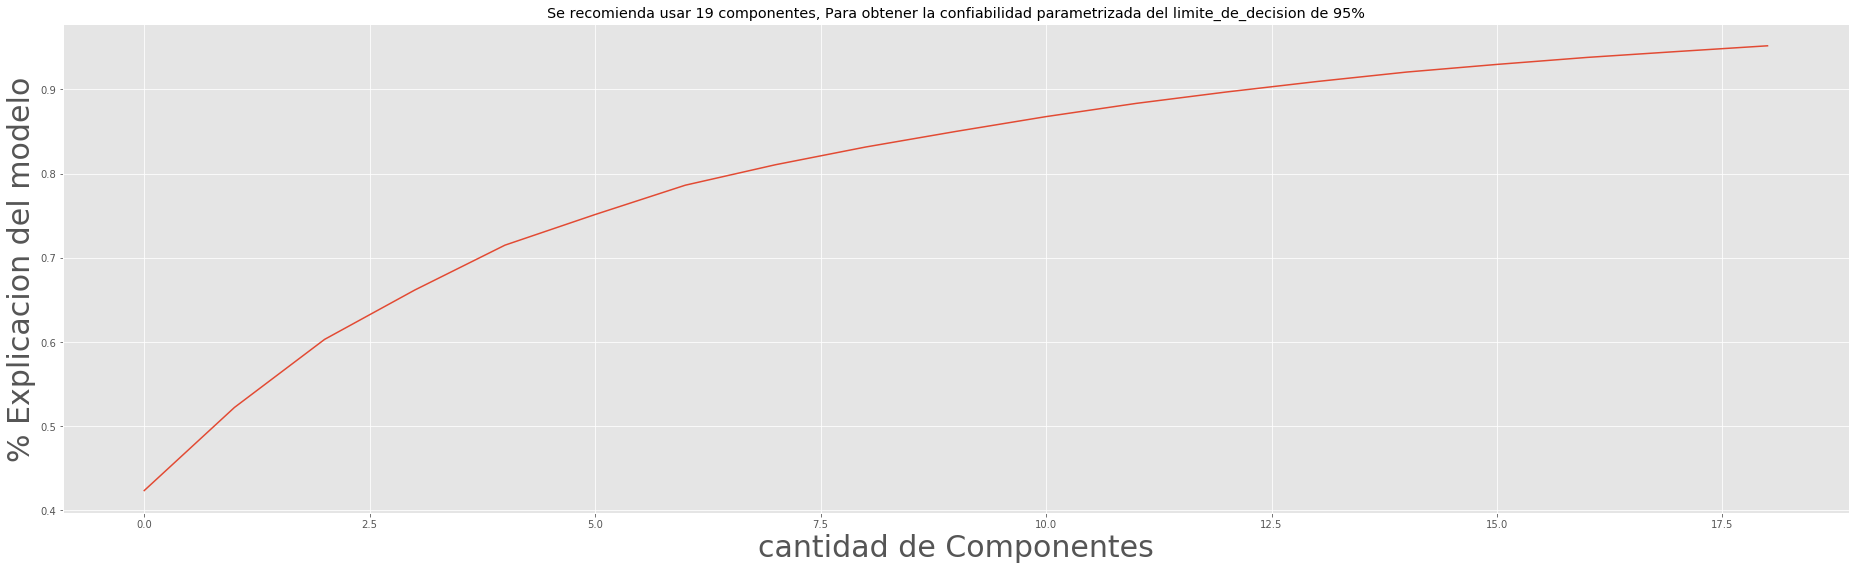

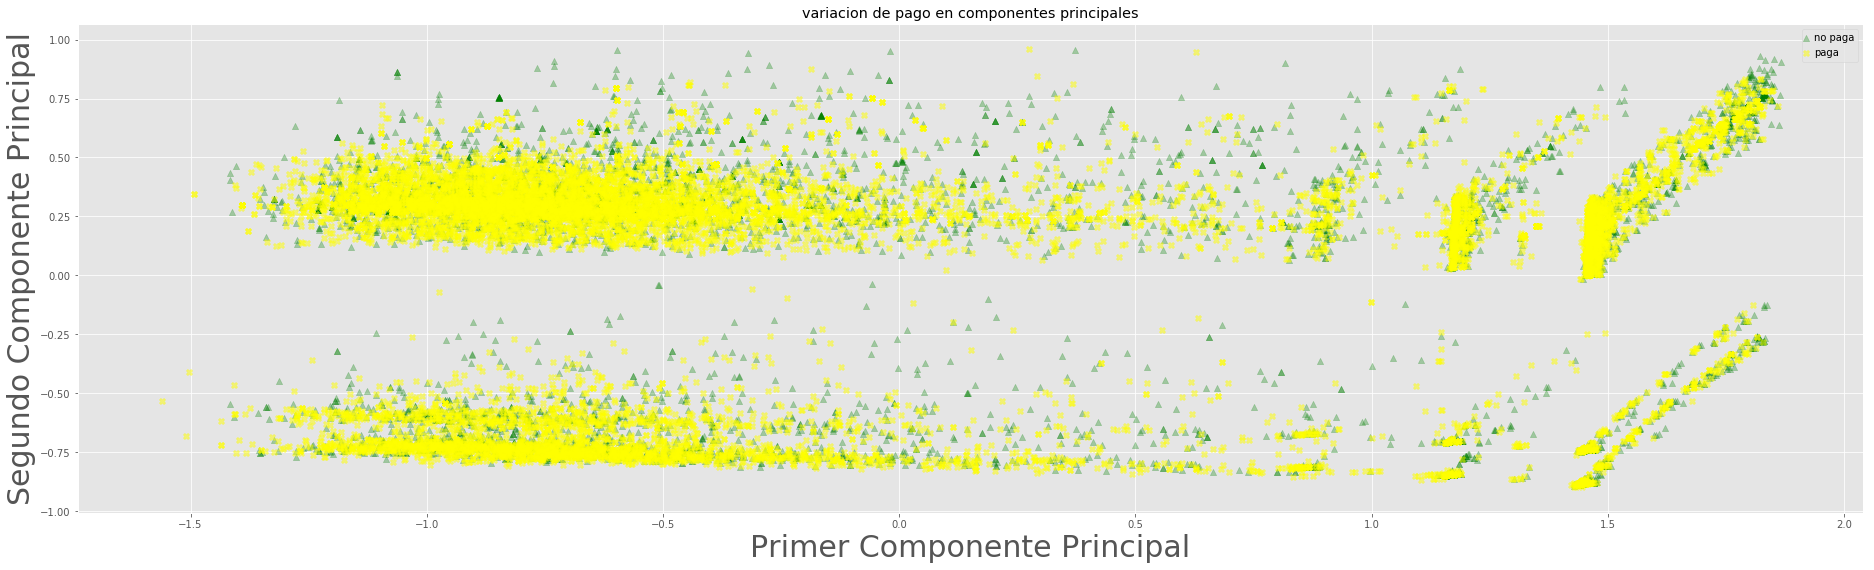

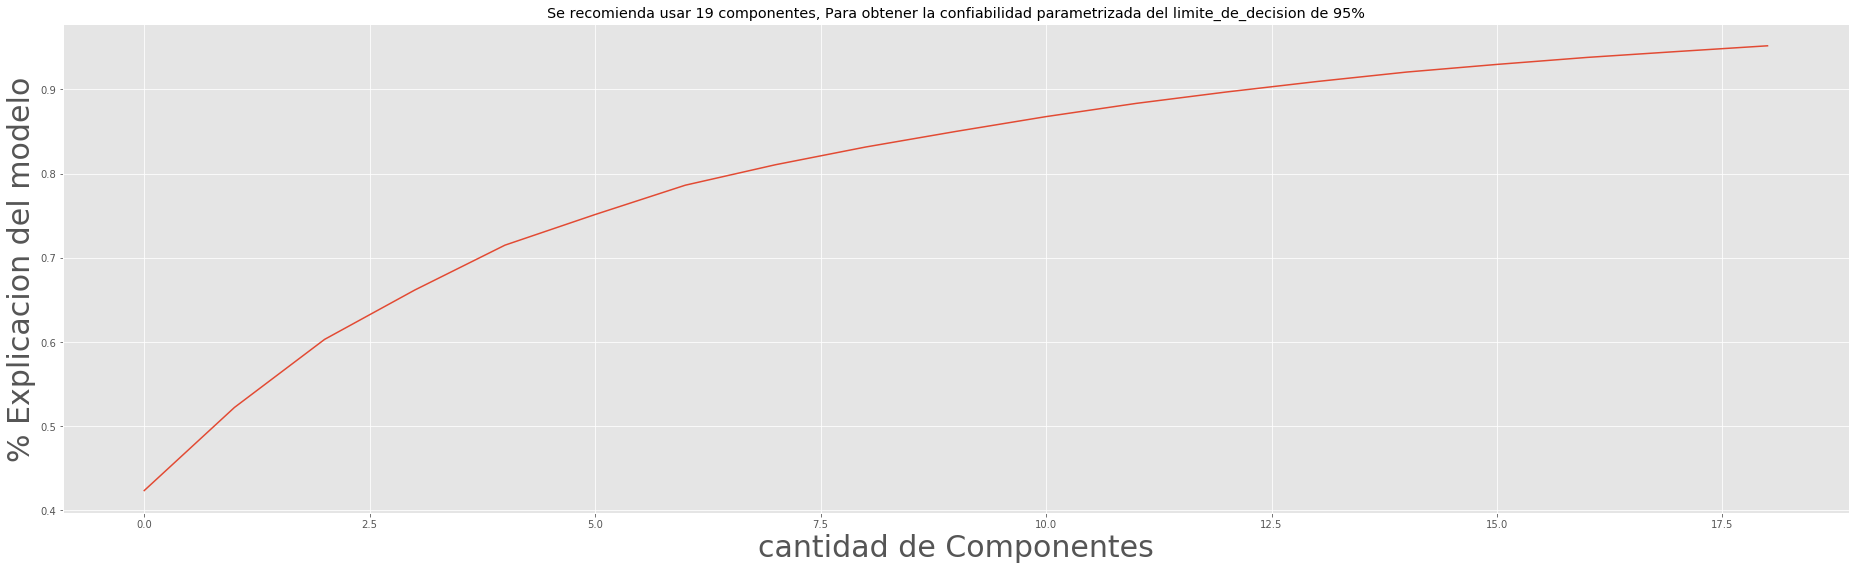

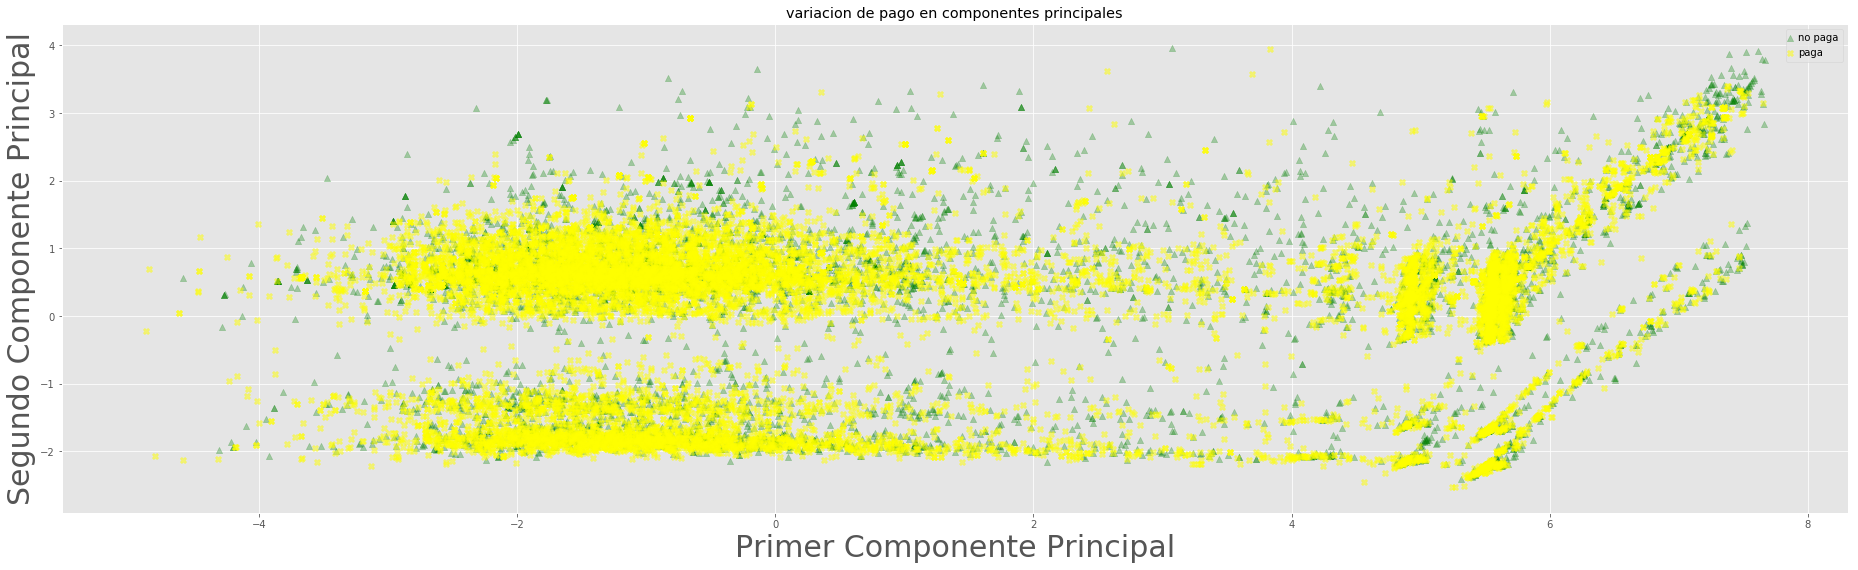

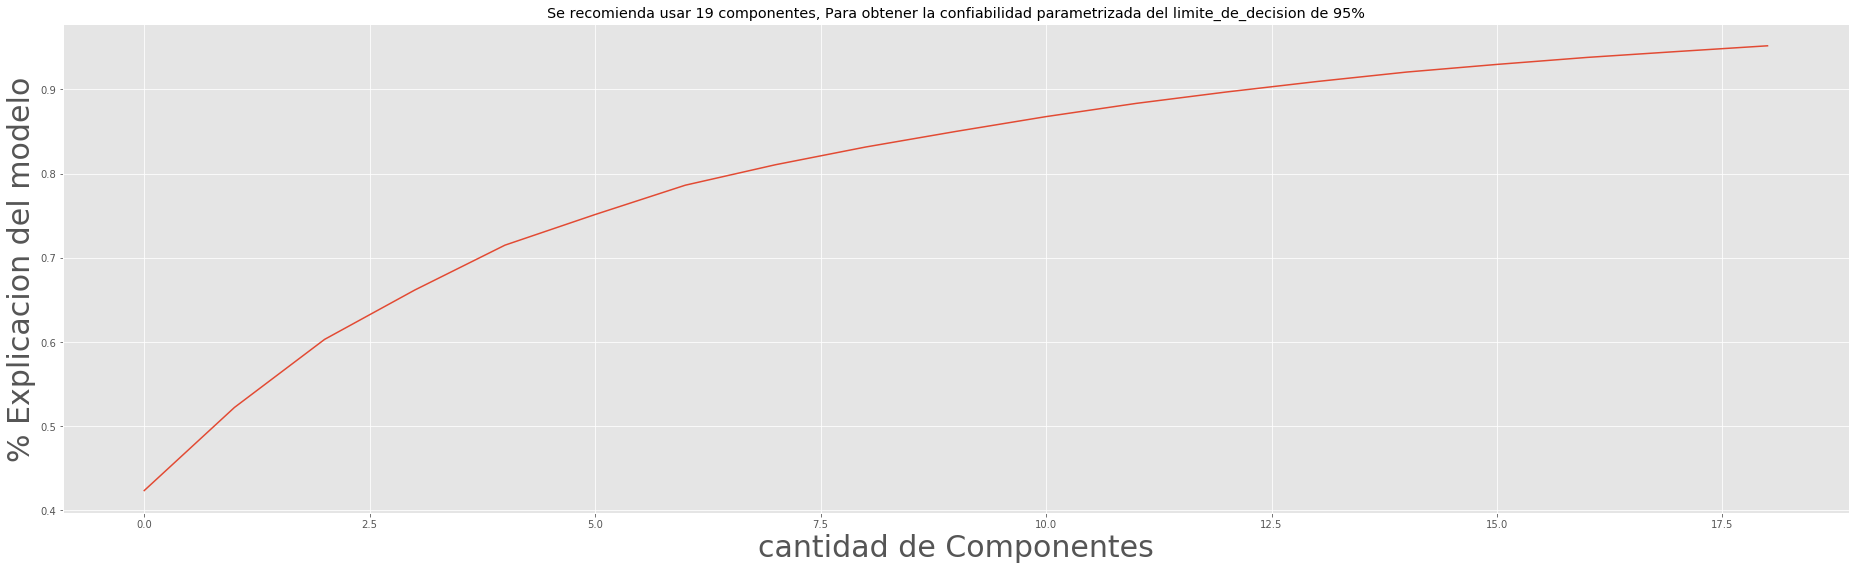

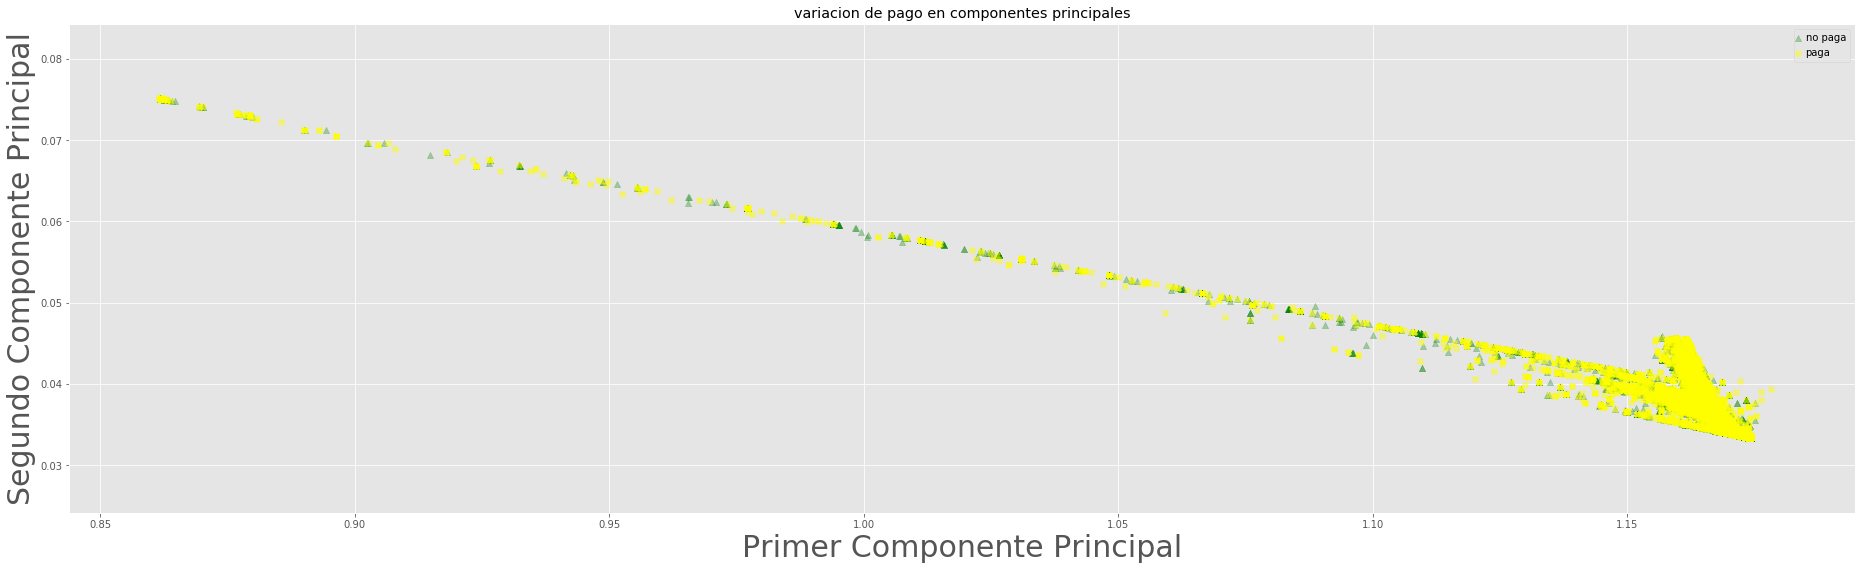

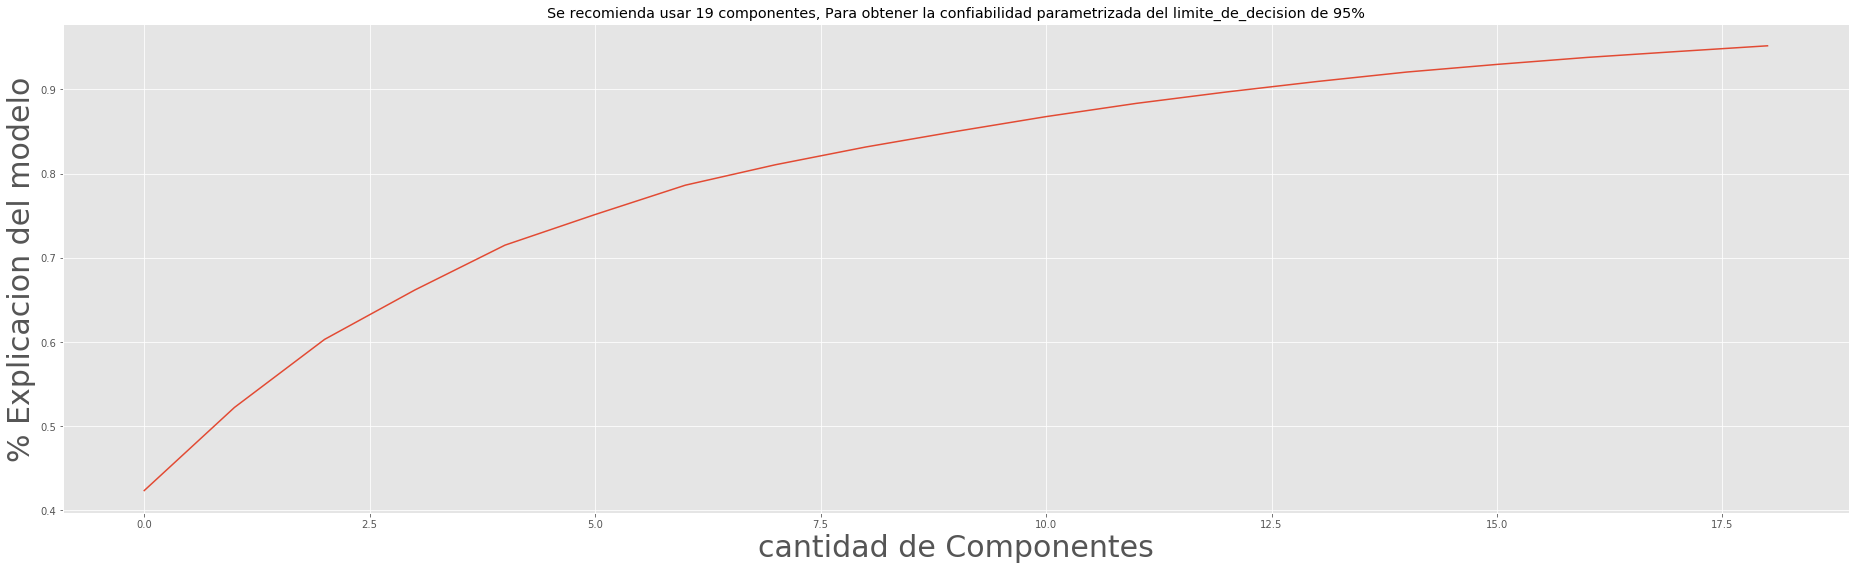

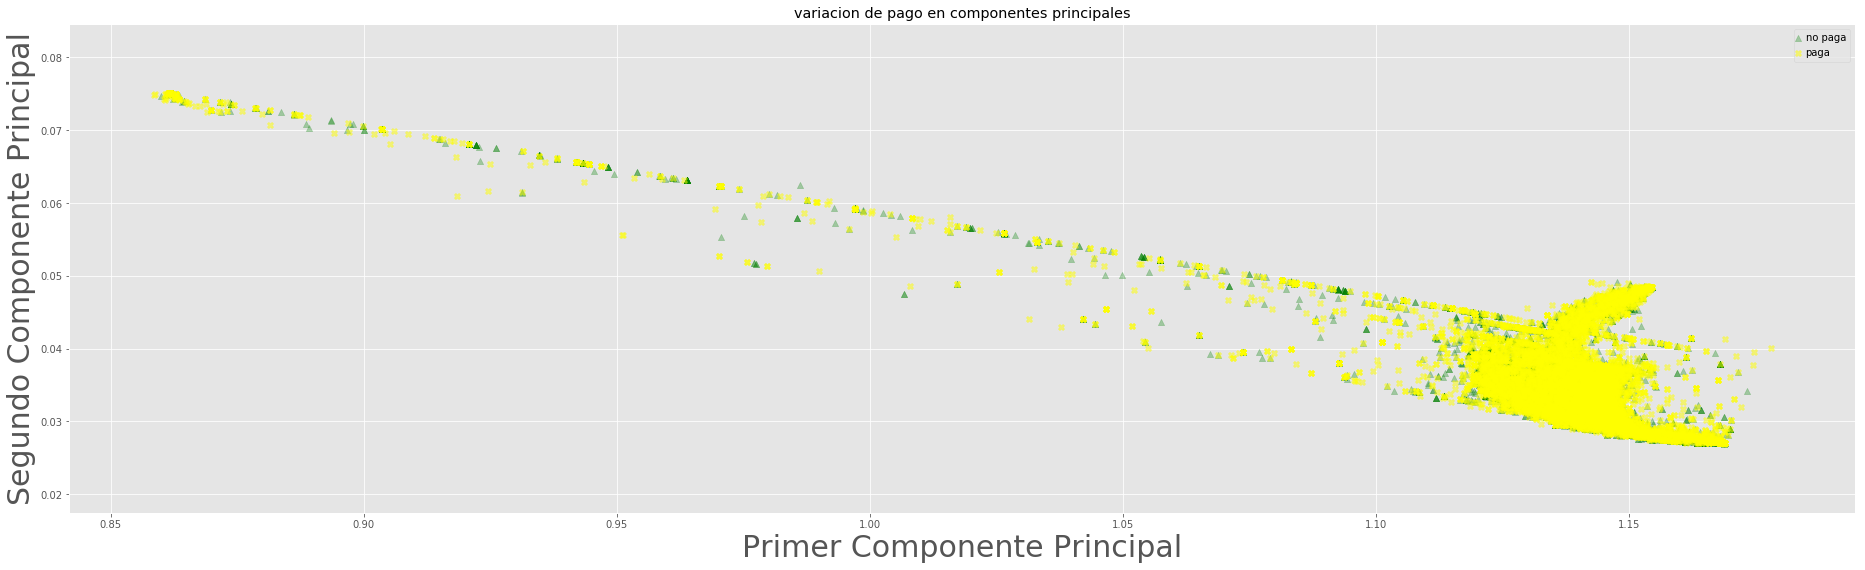

In [42]:
# obtiene la forma grafica de los componentes principales
grafica_componentes_reducidos_min_max_scaler = graficar_dimensiones_principales(componentes_reducidos_min_max_scaler, valores_componentes_reducidos_min_max_scaler, df_redimensionado, variable_a_predecir)
grafica_componentes_reducidos_standard_scaler = graficar_dimensiones_principales(componentes_reducidos_standard_scaler, valores_componentes_reducidos_standard_scaler, df_redimensionado, variable_a_predecir)
grafica_componentes_reducidos_normalizer_l1 = graficar_dimensiones_principales(componentes_reducidos_normalizer_l1, valores_componentes_reducidos_normalizer_l1, df_redimensionado, variable_a_predecir)
grafica_componentes_reducidos_normalizer_l2 = graficar_dimensiones_principales(componentes_reducidos_normalizer_l2, valores_componentes_reducidos_normalizer_l2, df_redimensionado, variable_a_predecir)

# guarda el promedio de las componentes recomendados por las normalizaciones realizadas 
total_componentes_recomendados = round((valores_componentes_reducidos_min_max_scaler.shape[1] + valores_componentes_reducidos_standard_scaler.shape[1] + valores_componentes_reducidos_normalizer_l1.shape[1] + valores_componentes_reducidos_normalizer_l2.shape[1])/4)

# Crea el dataset con los componentes principales

In [43]:
dataset_recomendado_descendente = obtener_componentes_principales(df_redimensionado, variable_a_predecir, total_componentes_recomendados, 'descendente')
dataset_recomendado_ascendente  = obtener_componentes_principales(df_redimensionado, variable_a_predecir, total_componentes_recomendados, 'ascendente')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  if __name__ == '__main__':


# Genera datasets para entrenamiento y validacion, con la finalidad de hacer verificacion con Matriz de Confusion y Curva ROC 

In [44]:
# obtengo los datasets de entrenamiento y validacion, para verificar si el ejercicio si esta dando una buena respuesta
# al utilizar los algoritmos en el modelo actual
dataset_entrenamiento, dataset_validacion = generar_datasets_entrenamiento_validacion(dataset_recomendado_ascendente,limite_de_decision)

# <center>7. ENTRENAMIENTO DEL MODELO Y ELECCIÓN DEL CLASIFICADOR </center>

# Crea el dataset para usar el clasificador

In [45]:
# obtiene el dataset en 2 conjuntos de datos, uno de entrenamiento y otro de prueba
conjunto_de_datos_para_clasificador = crear_conjunto_de_datos_para_clasificador (df_redimensionado, variable_a_predecir, tamano_conjunto_de_entrenamiento)

# obtiene la evaluacion de los clasificadores con roc auc, la matriz de confusion, el accuracy, recall, precision, f1-score, promedio cross validation.

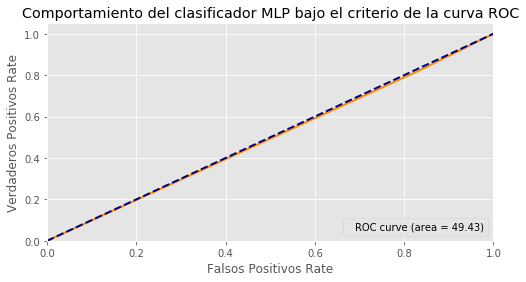

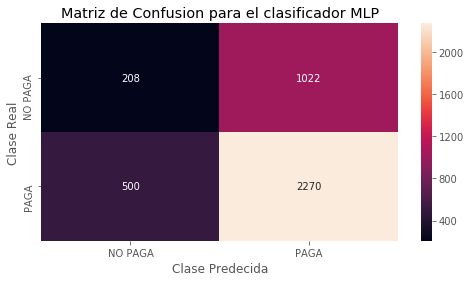

Accuracy:  61.95 %
Precision:  68.955 %
Recall:  81.949 %
F1-Score:  74.893 %
El promedio de Cross Validation para  10  validaciones es:  61.363 % con una variabilidad de +/-  0.912 %


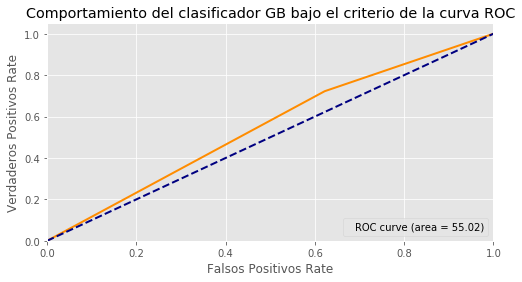

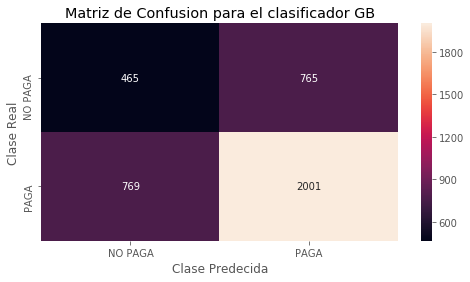

Accuracy:  61.65 %
Precision:  72.343 %
Recall:  72.238 %
F1-Score:  72.29 %
El promedio de Cross Validation para  10  validaciones es:  72.868 % con una variabilidad de +/-  6.7 %


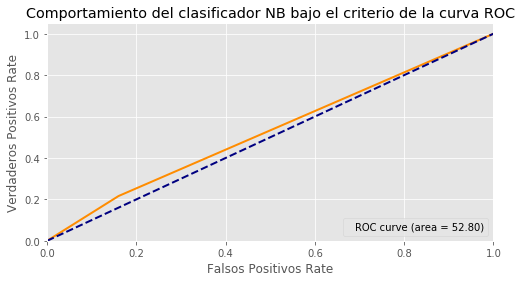

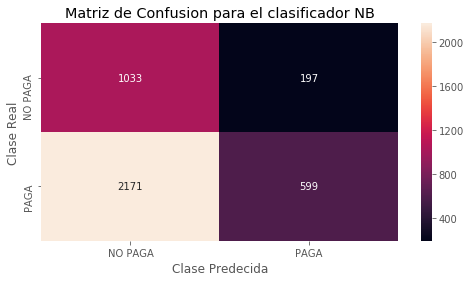

Accuracy:  40.8 %
Precision:  75.251 %
Recall:  21.625 %
F1-Score:  33.595 %
El promedio de Cross Validation para  10  validaciones es:  40.419 % con una variabilidad de +/-  0.871 %


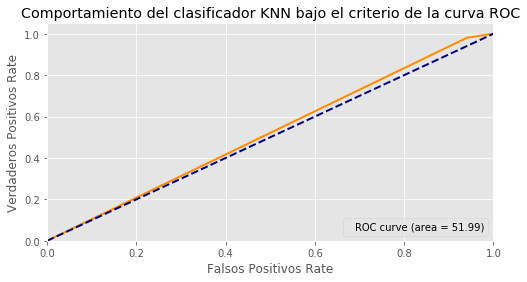

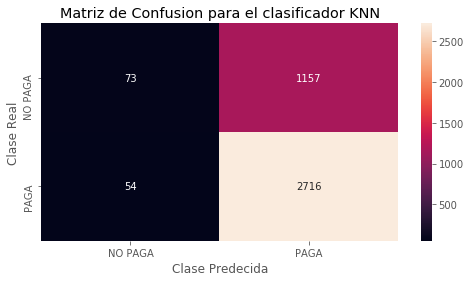

Accuracy:  69.725 %
Precision:  70.127 %
Recall:  98.051 %
F1-Score:  81.77 %
El promedio de Cross Validation para  10  validaciones es:  69.413 % con una variabilidad de +/-  0.512 %


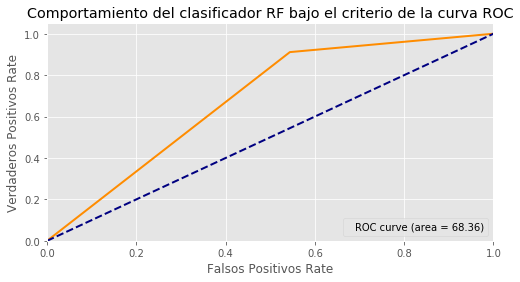

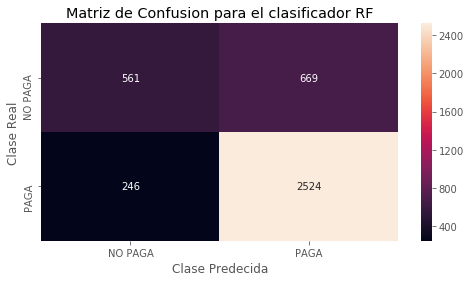

Accuracy:  77.125 %
Precision:  79.048 %
Recall:  91.119 %
F1-Score:  84.655 %
El promedio de Cross Validation para  10  validaciones es:  77.019 % con una variabilidad de +/-  0.967 %


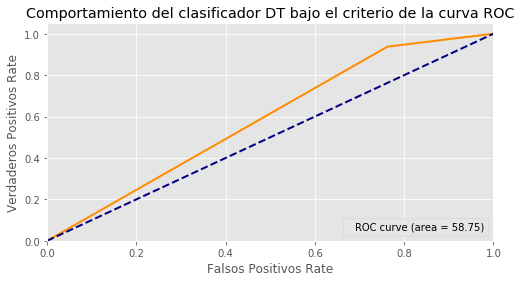

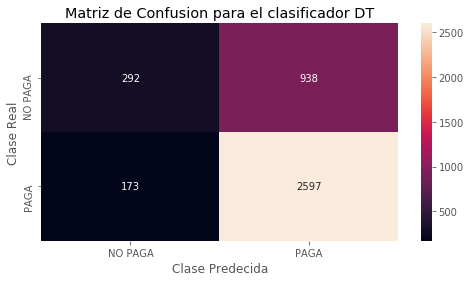

Accuracy:  72.225 %
Precision:  73.465 %
Recall:  93.755 %
F1-Score:  82.379 %
El promedio de Cross Validation para  10  validaciones es:  71.094 % con una variabilidad de +/-  0.746 %


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

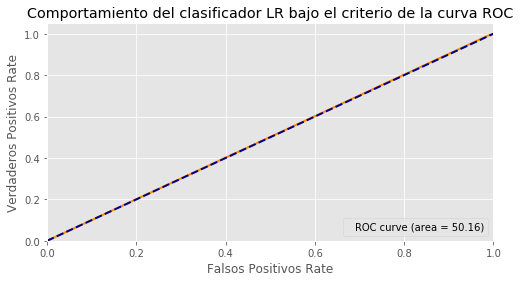

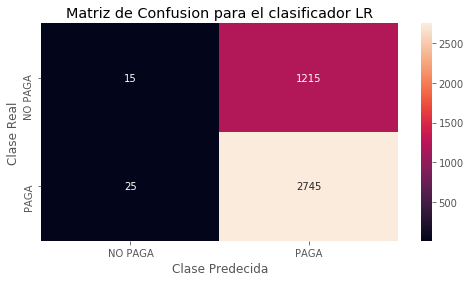

Accuracy:  69.0 %
Precision:  69.318 %
Recall:  99.097 %
F1-Score:  81.575 %
El promedio de Cross Validation para  10  validaciones es:  68.981 % con una variabilidad de +/-  0.239 %


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iter

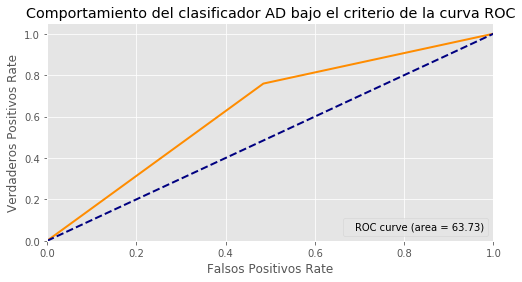

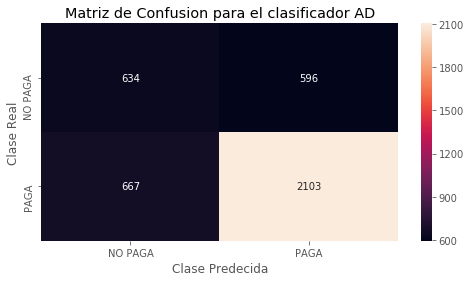

Accuracy:  68.425 %
Precision:  77.918 %
Recall:  75.921 %
F1-Score:  76.906 %
El promedio de Cross Validation para  10  validaciones es:  70.831 % con una variabilidad de +/-  0.426 %


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iter

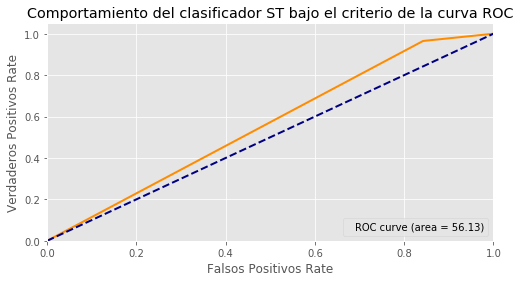

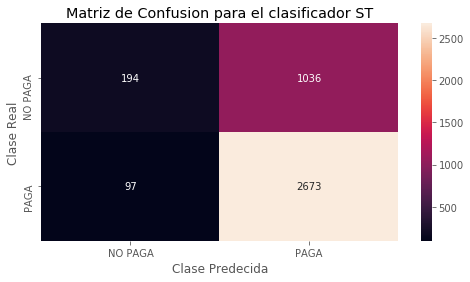

Accuracy:  71.675 %
Precision:  72.068 %
Recall:  96.498 %
F1-Score:  82.513 %
El promedio de Cross Validation para  10  validaciones es:  70.831 % con una variabilidad de +/-  0.426 %


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iter

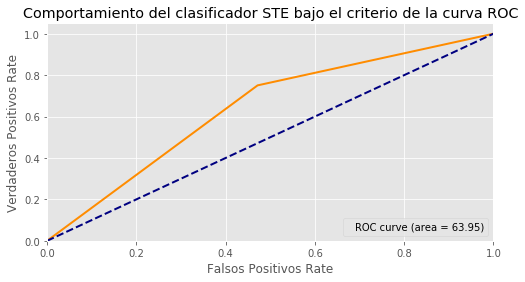

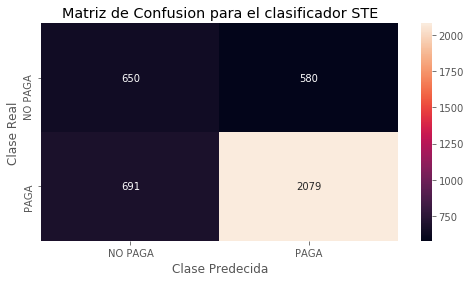

Accuracy:  68.225 %
Precision:  78.187 %
Recall:  75.054 %
F1-Score:  76.589 %
El promedio de Cross Validation para  10  validaciones es:  70.831 % con una variabilidad de +/-  0.426 %


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iter

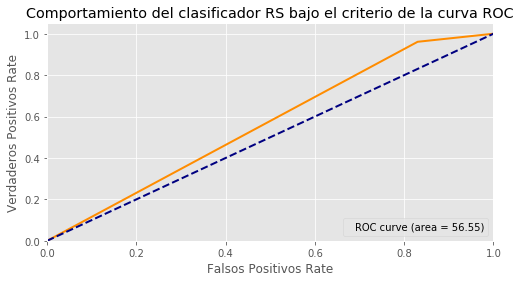

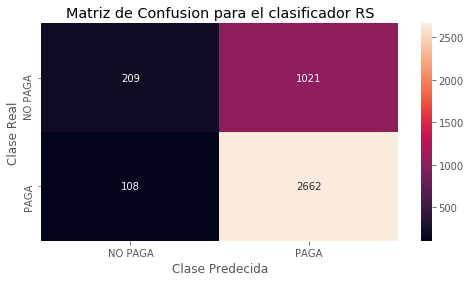

Accuracy:  71.775 %
Precision:  72.278 %
Recall:  96.101 %
F1-Score:  82.504 %
El promedio de Cross Validation para  10  validaciones es:  70.831 % con una variabilidad de +/-  0.426 %


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iter

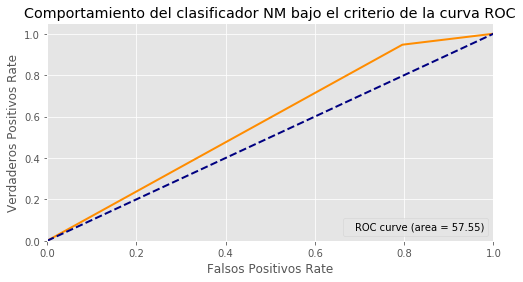

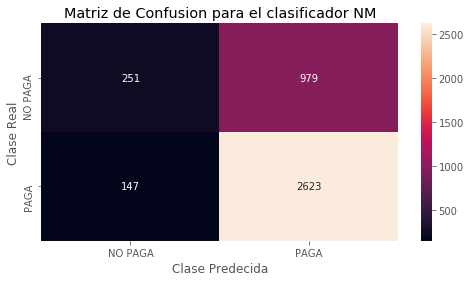

Accuracy:  71.85 %
Precision:  72.821 %
Recall:  94.693 %
F1-Score:  82.329 %
El promedio de Cross Validation para  10  validaciones es:  70.831 % con una variabilidad de +/-  0.426 %


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iter

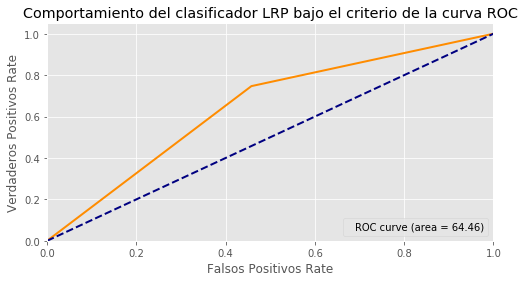

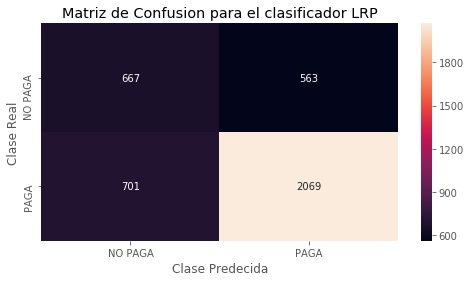

Accuracy:  68.4 %
Precision:  78.609 %
Recall:  74.693 %
F1-Score:  76.601 %
El promedio de Cross Validation para  10  validaciones es:  67.05 % con una variabilidad de +/-  1.106 %


In [46]:
tabla_ordenada_de_clasificadores , mejor_clasificador, prediccion_mejor_clasificador = evaluar_y_elegir_mejor_clasificador(clasificadores, conjunto_de_datos_para_clasificador, precision, columnas_esperadas_del_clasificador, criterio_de_clasificador)

# Muestra la evaluacion de los clasificadores ordenados de mayor a menor segun el criterio_de_clasificador

In [47]:
tabla_ordenada_de_clasificadores

,clasificador,area_bajo_la_curva,promedio_de_acierto_total,precision_no_paga,precision_si_paga,promedio_validacion_cruzada
1,LRP,64.460,64.460,54.228,74.693,67.050
2,STE,63.950,63.950,52.846,75.054,70.831
3,AD,63.733,63.733,51.545,75.921,70.831
4,RF,68.364,43.364,45.610,91.119,77.019
5,DT,58.747,33.747,23.740,93.755,71.094
6,NM,57.550,32.550,20.407,94.693,70.831
7,RS,56.546,31.546,16.992,96.101,70.831
8,ST,56.135,31.135,15.772,96.498,70.831
9,GB,55.022,30.022,37.805,72.238,72.868
10,NB,52.804,27.804,83.984,21.625,40.419


# Muestra cual fue el mejor clasificador de los evaluados

In [48]:
mejor_clasificador

'LRP'

# <center>8. PREDICCIÓN DEL MODELO CON DATA DE VERIFICACIÓN </center>

# Se genera el dataset de prueba final solo con las variables que tiene el dataframe reducido

In [49]:
# crea el nuevo dataset que contiene solo las variables que se obtuvieron al reducir el dataset
df_analisis_prediccion = df_validacion.drop(columns = list(set(list(df_validacion.columns)) - set(list(df_redimensionado.drop(columns = variable_a_predecir, axis = 1)))) , axis = 1)

# Se genera el conjunto de evaluacion final con el que se va a probar el clasificador

In [50]:
conjunto_de_evaluacion_final = crear_conjunto_de_datos_para_prediccion (df_redimensionado, variable_a_predecir, df_analisis_prediccion)

# obtiene el resultado de la evaluacion del clasificador

In [51]:
prediccion_final = entrenar_evaluar_y_predecir_usando_el_modelo_de_clasificacion (mejor_clasificador, conjunto_de_evaluacion_final, precision, cantidad_de_validaciones, 1)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iter

# crea un dataframe con todos los resultados obtenidos

In [52]:
# crea un dataframe vacio, para guardar los resulrados de la prediccion
dataframe_prediccion = pd.DataFrame()

#crea las columnas del dataframe apartir de los datos de evaluacion
dataframe_prediccion['llave'] = df_validacion['llave']
dataframe_prediccion['prediccion'] = prediccion_final

# guarda los valores ene le dataframe
dataframe_prediccion = dataframe_prediccion

# crea un archivo .csv con la respuesta del problema

In [53]:
dataframe_prediccion.to_csv('prediccion.csv',header=True, index=False)

In [56]:
# obtiene el tiempo de ejecucion hasta esta linea
print ('El tiempo de ejecucion total del notebook fue:', time.time() - tiempo_inicial_ejecucion_notebook)
print ('El tiempo de ejecucion total en minutos del notebook fue:', round((time.time() - tiempo_inicial_ejecucion_notebook) / 60 ,precision))

El tiempo de ejecucion total del notebook fue: 662.7462718486786
El tiempo de ejecucion total en minutos del notebook fue: 11.046
